In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

import lmfit
from kid_readout.measurement import plot_basic
from kid_readout.measurement.io import npy
from kid_readout.analysis.resonator import lmfit_resonator

In [2]:
npd = npy.NumpyDirectory('/Users/daniel/data/chosen_one.npd')

In [3]:
npd.node_names()

['SingleSweepStream0']

In [4]:
chosen_mod = npd.SingleSweepStream0

In [5]:
chosen_mod.sweep.fit_resonator(model=lmfit_resonator.LinearLossResonatorWithCable)

In [6]:
def decimate(sss, num_taps=256, downsample=8):
    f_nyquist = sss.stream.stream_sample_rate / 2
    x_lpf = filters.low_pass_fir(sss.x, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    q_lpf = filters.low_pass_fir(sss.q, num_taps=256, cutoff=f_nyquist / downsample,
                                 nyquist_freq=f_nyquist, decimate_by=downsample)
    t = sss.stream.sample_time[::downsample]
    size = min(t.size, x_lpf.size)
    return t[:size], x_lpf[:size], q_lpf[:size]

In [7]:
print("resonance frequency is {:.1f} MHz".format(1e-6 * chosen_mod.resonator.f_0))
print("internal loss is {:.3g} = 1 / {:.3g}".format(chosen_mod.resonator.loss_i, 1 / chosen_mod.resonator.loss_i))
print("coupling loss is {:.3g} = 1 / {:.3g}".format(chosen_mod.resonator.loss_c, 1 / chosen_mod.resonator.loss_c))

resonance frequency is 3409.7 MHz
internal loss is 8.14e-05 = 1 / 1.23e+04
coupling loss is 1.92e-05 = 1 / 5.22e+04


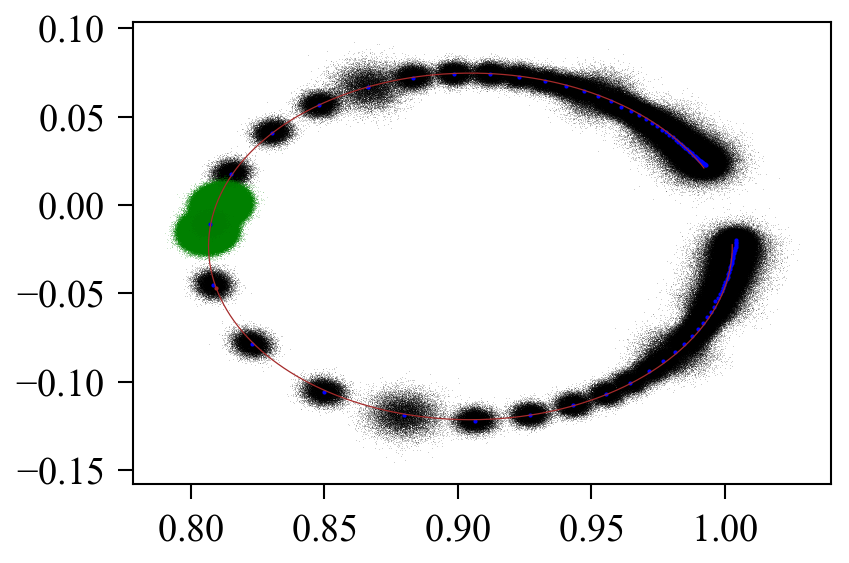

In [8]:
fig, ax = plt.subplots()
plot_basic.sss_complex_plane(axis=ax, sss=chosen_mod)

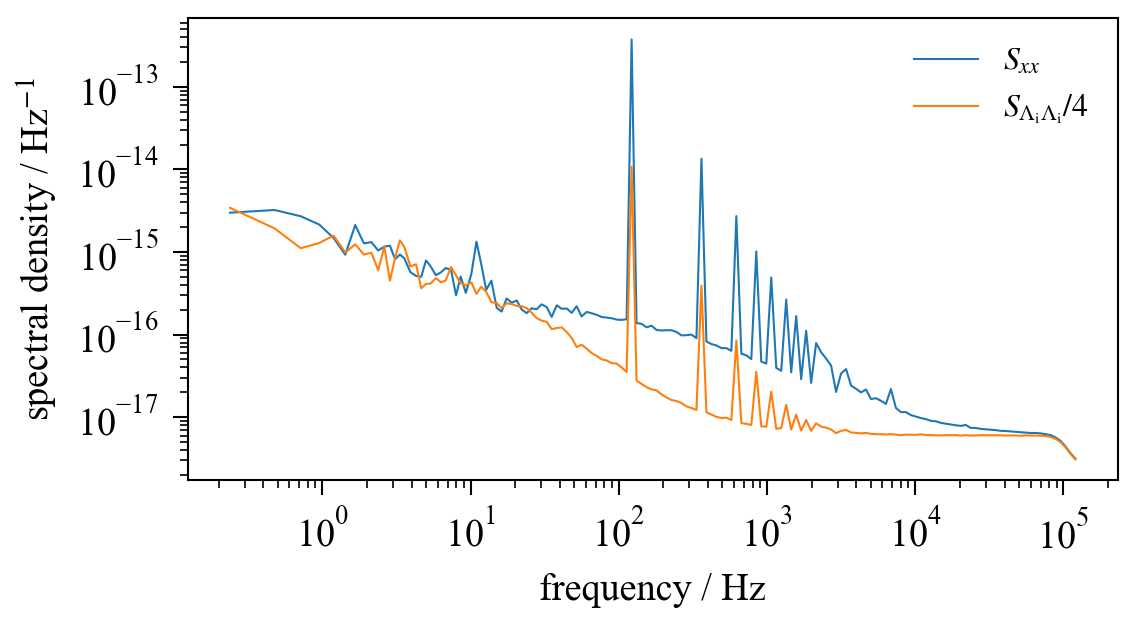

In [9]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency / Hz')
ax.set_ylabel('spectral density / Hz$^{-1}$')    
ax.plot(chosen_mod.S_frequency, chosen_mod.S_xx,
        linestyle='-', label='$S_{xx}$')
ax.plot(chosen_mod.S_frequency, chosen_mod.S_yy,
        linestyle='-', label='$S_{\Lambda_\mathrm{i} \Lambda_\mathrm{i}} / 4$'),
ax.legend(fontsize='x-small')

# Chopped data

In [10]:
# The automatic folding doesn't calculate the period samples correctly for this build
print(chosen_mod.stream.stream_sample_rate / 2**11)

x_fold = chosen_mod.fold(chosen_mod.x, period_samples=2**11)
size = x_fold.size
x_fold = np.roll(x_fold, size // 2)
time_fold = chosen_mod.stream.sample_time[:size]
time_scale = 1e3
x_scale = 1e6
n = time_fold.size

122.0703125


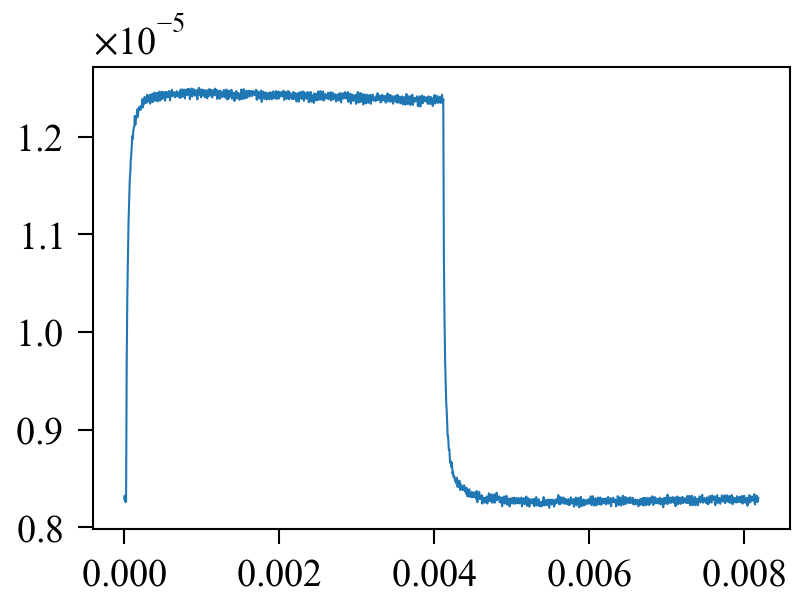

In [11]:
fig, ax = plt.subplots()
ax.plot(time_fold, x_fold)

In [12]:
def delta_x(t, t0, xbar, dx0, R_dn0, tau):
    x = np.zeros(t.size)
    x[t < t0] = xbar + dx0
    dx = dx0 / (1 + (1 + R_dn0 * tau) * (np.exp((t - t0) / tau) - 1))
    x[t >= t0] = xbar + dx[t >= t0]
    return x
    

delta_x_model = lmfit.Model(delta_x)
#delta_x_model.independent_vars = ['']


def fit(time, x, delay_samples=6):
    model = lmfit.Model(delta_x, independent_vars=['t', 'xbar', 'dx0'])  #, 't0'
    xbar = x[-delay_samples:].mean()
    dx0 = x[:delay_samples].mean() - xbar
    #t0 = time[delay_samples]
    params = model.make_params()
    params['t0'].value = time[delay_samples:delay_samples+2].mean()
    params['t0'].min = time[delay_samples]
    params['R_dn0'].value = np.sign(dx0) / 2
    params['tau'].value = 0.0001
    if dx0 > 0:
        params['R_dn0'].min = 0
    else:
        params['R_dn0'].max = 0
    result = model.fit(x, t=time, xbar=xbar, dx0=dx0, params=params)  #, t0=t0
    return result

def plot_result(axis, time, result, initial=False):
    axis.set_xlabel('time / ms')
    axis.set_ylabel('$10^6 \; x$', rotation='horizontal', labelpad=15)
    time_scale = 1e3
    x_scale = 1e6
    data = result.data
    #time = what?
    axis.plot(time_scale * time,
              x_scale * data,
              '.', color='C0', label='data')
    if initial:
        axis.plot(time_scale * time,
                  x_scale * result.init_fit,
                  ':', color='gray', label='initial')
    axis.plot(time_scale * time,
              x_scale * result.best_fit,
              '-', color='C3', label='fit')
    tau = result.params['tau']
    R_dx0 = result.params['R_dn0']
    axis.set_title((r'$\tau =$' + ' {:.0f} '.format(1e6 * tau.value) +
                    r'$\mu \mathrm{s} \, (1 \pm$' + ' {:.2f})'.format(tau.stderr / tau.value)),
                   fontsize='x-small')
    axis.legend()
    

def plot_residual(axis, time, result, initial=False):
    axis.set_xlabel('time / ms')
    axis.set_ylabel('$10^6 \; x$', rotation='horizontal', labelpad=15)
    time_scale = 1e3
    x_scale = 1e6
    data = result.data
    #time = what?
    axis.plot(time_scale * time,
              x_scale * (data - result.best_fit),
              '.', color='C0', label='data - fit')
    axis.axhline(0, color='C3')
    tau = result.params['tau']
    R_dx0 = result.params['R_dn0']
    axis.set_title((r'$\tau =$' + ' {:.0f} '.format(1e6 * tau.value) +
                    r'$\mu \mathrm{s} \, (1 \pm$' + ' {:.2f})'.format(tau.stderr / tau.value)),
                   fontsize='x-small')
#    axis.legend()

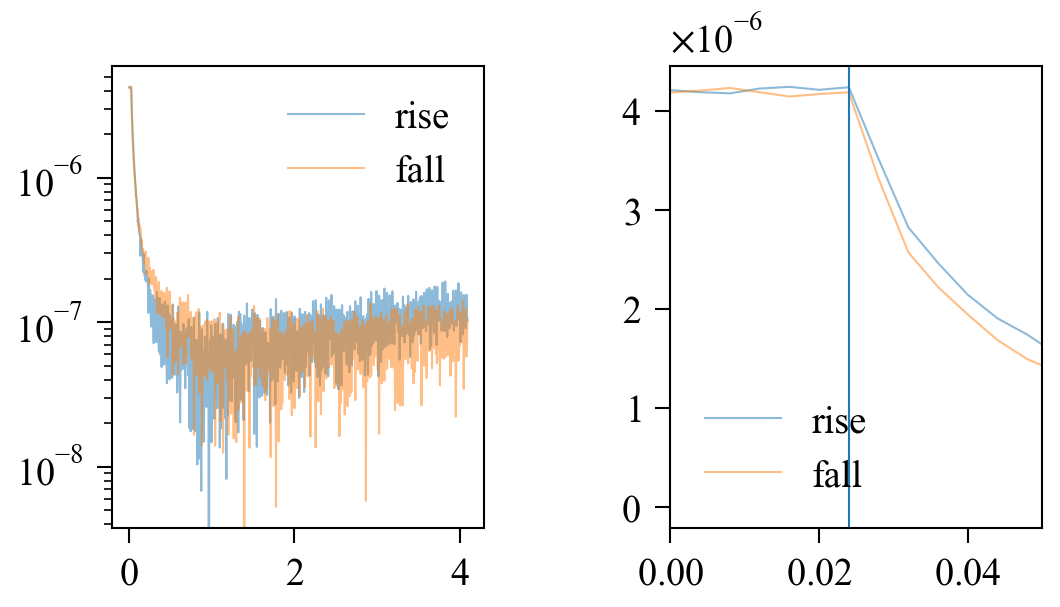

In [13]:
x_fold_left = x_fold[:n // 2]
time_fold_left = time_fold[:n // 2]
x_fold_right = x_fold[n // 2:]
time_fold_right = time_fold[n // 2 :]
fig, (ax_full, ax_detail) = plt.subplots(1, 2, figsize=(4, 2), gridspec_kw={'wspace': 0.5})
for ax in (ax_full, ax_detail):
    ax.plot(time_scale * time_fold_left, x_fold_left.max() - x_fold_left, label='rise', alpha=0.5)
    ax.plot(time_scale * time_fold_left, x_fold_right - x_fold_right.min(), label='fall', alpha=0.5)
    ax.legend()
    
ax_full.set_yscale('log')
ax_detail.set_xlim(0, 0.05)
ax_detail.axvline(time_scale * time_fold_left[6])

t_fall = time_fold[n // 2:9 * n // 16]
x_fall = x_fold[n // 2:9 * n // 16]

t_rise = time_fold[0:1 * n // 16]
x_rise = x_fold[0:1 * n // 16]

In [14]:
length = 0.5e-3
num_samples = (time_fold < length).sum()
t_rise = time_fold[:num_samples]
x_rise = x_fold[:num_samples]
t_fall = time_fold[n // 2:n // 2 + num_samples]
x_fall = x_fold[n // 2:n // 2 + num_samples]

In [15]:
result_fixed_fall = fit(t_fall, x_fall)
print(result_fixed_fall.fit_report())

[[Model]]
    Model(delta_x)
[[Fit Statistics]]
    # function evals   = 89
    # data points      = 125
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -4356.645
    Bayesian info crit = -4348.160
[[Variables]]
    t0:      0.00412000 +/- 0        (0.00%) (init= 0.004122)
    R_dn0:   65539.8228 +/- 0        (0.00%) (init= 0.5)
    tau:     0.00012775 +/- 0        (0.00%) (init= 0.0001)



In [22]:
delta_x_model.fit?

In [16]:
result_fixed_rise = fit(t_rise, x_rise)
print(result_fixed_rise.fit_report())

[[Model]]
    Model(delta_x)
[[Fit Statistics]]
    # function evals   = 354
    # data points      = 125
    # variables        = 3
    chi-square         = 0.000
    reduced chi-square = 0.000
    Akaike info crit   = -3991.026
    Bayesian info crit = -3982.541
[[Variables]]
    t0:      2.4002e-05 +/- 0        (0.00%) (init= 2.6e-05)
    R_dn0:  -0.00038816 +/- 0        (0.00%) (init=-0.5)
    tau:     2.9528e-05 +/- 0        (0.00%) (init= 0.0001)



In [17]:
result_fixed_fall.values

{'R_dn0': 65539.82282586956,
 't0': 0.0041200007236702474,
 'tau': 0.00012774916645777912}

In [18]:
result_fixed_rise

In [19]:
delay_samples=6
xbar = x_rise[-delay_samples:].mean()
dx0 = x_rise[:delay_samples].mean() - xbar

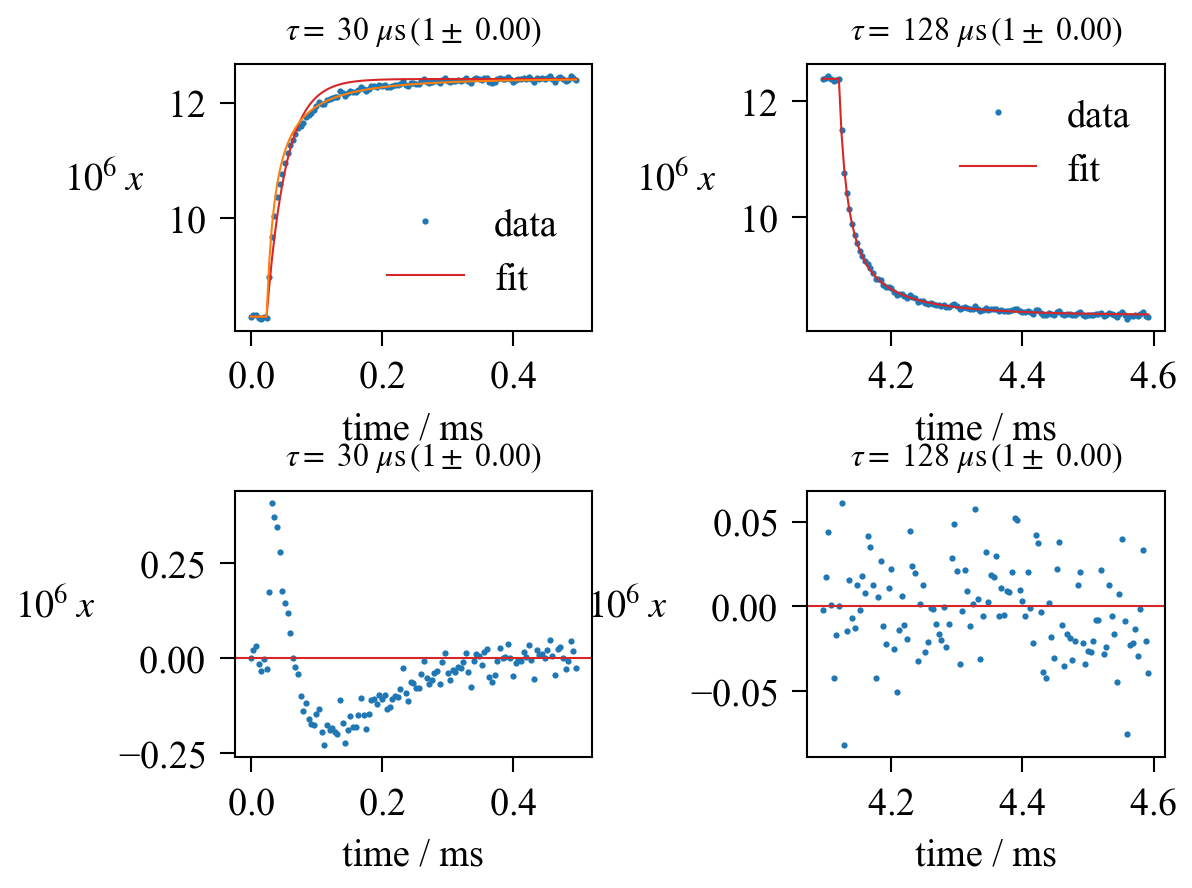

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(4, 3), gridspec_kw={'wspace': 0.6, 'hspace': 0.6})
(ax_rise, ax_fall), (ax_rise_residual, ax_fall_residual) = axes
plot_result(axis=ax_rise, time=t_rise, result=result_fixed_rise)
plot_result(axis=ax_fall, time=t_fall, result=result_fixed_fall)
plot_residual(axis=ax_rise_residual, time=t_rise, result=result_fixed_rise)
plot_residual(axis=ax_fall_residual, time=t_fall, result=result_fixed_fall)

ax_rise.plot(time_scale * t_rise, x_scale * delta_x(t=t_rise, t0=t_rise[delay_samples], xbar=xbar, dx0=dx0,
                             R_dn0=result_fixed_fall.values['R_dn0'], tau=result_fixed_fall.values['tau']),
            color='C1')


# Many free parameters

In [21]:
result_fall = delta_x_model.fit(x_fall, t=t_fall, t0=t_fall.min(), xbar=x_fall[-1],
                                dx0=x_fall[0] - x_fall[-1], R_tau_dn0=1, tau=0.0001)
tau_fall = result_fall.params['tau']
print(result_fall.fit_report())

/Users/daniel/code/miniconda3/envs/thesis/lib/python2.7/site-packages/lmfit/model.py:689: UserWarning: The keyword argument R_tau_dn0 does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)
/Users/daniel/code/miniconda3/envs/thesis/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


ValueError: The input contains nan values

In [ ]:
result_rise = delta_x_model.fit(x_rise, t=t_rise, t0=t_rise.min(), xbar=x_rise[-1],
                                dx0=x_rise[0] - x_rise[-1], R_tau_dN0=1, tau=0.0001)
tau_rise = result_rise.params['tau']
print(result_rise.fit_report())

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('time / ms')
ax.set_ylabel('$10^6 \; x$', rotation='horizontal', labelpad=20)

ax.plot(time_scale * t_fall,
        x_scale * x_fall,
        '.', color='C0', label='data')
#ax.plot(time_scale * t_fall,
#        x_scale * result_fall.init_fit,
#        ':', color='C1')
ax.plot(time_scale * t_fall,
        x_scale * result_fall.best_fit,
        '-', color='C3', label='fit')
ax.legend()
print('tau = {:.1f} +/- {:.1f} us'.format(1e6 * tau_fall.value, 1e6 * tau_fall.stderr))

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2))
ax.set_xlabel('time / ms')
ax.set_ylabel('$10^6 \; x$', rotation='horizontal', labelpad=20)

ax.plot(time_scale * t_rise,
        x_scale * x_rise,
        '.', color='C0', label='data')
#ax.plot(time_scale * t_rise,
#        x_scale * result_rise.init_fit,
#        ':', color='C1')
ax.plot(time_scale * t_rise,
        x_scale * result_rise.best_fit,
        '-', color='C3', label='fit')
ax.legend()
print('tau = {:.1f} +/- {:.1f} us'.format(1e6 * tau_rise.value, 1e6 * tau_rise.stderr))